In [1]:
%pip install ollama

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install numpy 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [4]:
!pip install pandas --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


### Task 1

In [5]:
import ollama

def prompt_on_image(image_path, model="ministral-3:3b"):
    """
    Runs a prompt on an image using Ollama and returns the generated text.

    Args:
        image_path (str): Path to the image file.
        prompt (str): The prompt/question to ask about the image.
        model (str): The Ollama model to use (default: "llava:latest").

    Returns:
        str: The generated text response.
    """
    prompt = "Describe briefly what happens in this image, in English."

    response = ollama.generate(
        model=model,
        prompt=prompt,
        images=[image_path]
    )
    return response['response']

In [6]:
# Example usage:
result = prompt_on_image("frames/bear.jpg")
print(result)

This image depicts a grizzly bear standing on a rocky outcrop or ledge. The bear appears to be in a natural, forested environment with lush green and autumn-colored foliage in the background. It looks alert and is positioned with its head turned slightly to the side, possibly observing its surroundings.


In [7]:
result = prompt_on_image("frames/frame_0050.jpg")
print(result)

In this image, a white rhinoceros is seen grazing on grass. The animal is bending its head down to eat, showcasing its large, flat upper lips used for carefully picking and consuming vegetation. The scene appears to be in a natural or semi-natural environment, likely a grassland or savanna.


In [8]:
result = prompt_on_image("frames/frame_0035.jpg")
print(result)

This image depicts a cat sitting or crouching in a natural, green outdoor setting, likely a forest or bushy area. The cat appears to be in a relaxed yet attentive pose, surrounded by dense foliage. It looks calm and observant, possibly scanning its environment.


### Task 2

In [9]:
import numpy as np

def get_text_embedding(text, model="embeddinggemma"):
    """
    Computes the embedding of a string using Ollama's embeddinggemma model.

    Args:
        text (str): The input string to embed.
        model (str): The Ollama embedding model to use.

    Returns:
        np.ndarray: The embedding as a NumPy array.
    """
    response = ollama.embeddings(
        model=model,
        prompt=text
    )
    embedding = response['embedding']
    return np.array(embedding)


In [10]:
# Example usage:
emb = get_text_embedding("A bear in the forest.")
print(emb.shape)

(768,)


### Task 3

In [11]:
import pandas as pd

def create_model_df(filenames, descriptions, embeddings):
    """
    Creates a Pandas DataFrame with columns: filename, description, embedding.

    Args:
        filenames (list of str): List of image filenames.
        descriptions (list of str): List of image descriptions.
        embeddings (list of np.ndarray): List of embeddings (NumPy arrays).

    Returns:
        pd.DataFrame: The resulting DataFrame.
    """
    df = pd.DataFrame({
        "filename": filenames,
        "description": descriptions,
        "embedding": embeddings
    })
    return df

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None) 

In [14]:
# Example usage:
filenames = ["frames/bear.jpg", "frames/frame_0050.jpg"]
descriptions = ["A bear in the forest.", "A rhinoceros in the forest."]
embeddings = [get_text_embedding(desc) for desc in descriptions]
model_df = create_model_df(filenames, descriptions, embeddings)
print(model_df)

                filename                  description  \
0        frames/bear.jpg        A bear in the forest.   
1  frames/frame_0050.jpg  A rhinoceros in the forest.   

                                           embedding  
0  [-0.11828449368476868, -0.03932224214076996, 0...  
1  [-0.14271818101406097, -0.019169874489307404, ...  


### Task 4

In [15]:
import os
import random

frames_folder = 'frames'
all_jpg_files = [i for i in os.listdir(frames_folder) if i.lower().endswith(".jpg")]
filenames = random.sample(all_jpg_files,5)

filenames

['frame_0167.jpg',
 'frame_0105.jpg',
 'frame_0053.jpg',
 'frame_0088.jpg',
 'frame_0079.jpg']

In [18]:
descriptions = [prompt_on_image(os.path.join(frames_folder, fname)) for fname in filenames]
embeddings = [get_text_embedding(desc) for desc in descriptions]

model = pd.DataFrame({
        "filename": filenames,
        "description": descriptions,
        "embedding": embeddings
    })

print(model)

         filename  \
0  frame_0167.jpg   
1  frame_0105.jpg   
2  frame_0053.jpg   
3  frame_0088.jpg   
4  frame_0079.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  \
0                                                                                                                                                            This image shows a close-up of a snake, likely a species of pit viper or similar venomous reptile. The snake appears to be coiled or resting,

In [19]:
def find_most_similar(model_df, new_embedding):
    """
    Finds the most similar entry in the model DataFrame to the new embedding.

    Args:
        model_df (pd.DataFrame): DataFrame with 'embedding' column (NumPy arrays).
        new_embedding (np.ndarray): The embedding to compare.

    Returns:
        tuple: (filename, description) of the most similar entry.
    """
    # Stack embeddings into a 2D array
    embeddings = np.stack(model['embedding'].values)
    # Normalize for cosine similarity
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    new_embedding_norm = new_embedding / np.linalg.norm(new_embedding)
    # Compute cosine similarities
    similarities = embeddings_norm @ new_embedding_norm
    idx = np.argmax(similarities)
    return model_df.iloc[idx]['filename'], model_df.iloc[idx]['description']

In [20]:
filename, description = find_most_similar(model, get_text_embedding("A cat is sitting on a windowsill looking outside."))
print(filename, description)

frame_0105.jpg This image depicts a close-up of a cat with striking yellow eyes. The cat appears to be looking directly at the camera with an attentive and somewhat curious expression. Its fur is soft and slightly textured, and it has a calm, focused demeanor. The background is blurred and neutral, putting emphasis on the cat's face.


In [22]:
filename, description = find_most_similar(model, get_text_embedding("An animal in the water"))
print(filename, description)

frame_0079.jpg In this image, a bear is partially submerged in water, likely playing or swimming. The bear appears to be in a relaxed and playful state, with its head and upper body above the water, while its tail is visible beneath the surface. The scene suggests a moment of leisure or natural behavior in a water environment.


In [24]:
filename, description = find_most_similar(model, get_text_embedding("An animal group of animals"))
print(filename, description)

frame_0053.jpg This image depicts a large group of King penguins walking together on a sandy or rocky shore. The penguins appear to be moving in a coordinated manner, possibly forming part of a migration or a communal movement. In the background, there is a crowd of people observing the scene, likely tourists or researchers documenting the wildlife. The setting suggests a coastal or beach environment, possibly in a region known for penguin colonies.


### Task 5

In [25]:
def save_model_csv(model_df, filename):
    """
    Saves the model DataFrame to a CSV file, converting embeddings to strings.
    """
    df_to_save = model_df.copy()
    df_to_save['embedding'] = df_to_save['embedding'].apply(lambda x: ','.join(map(str, x.tolist())))
    df_to_save.to_csv(filename, index=False)

def load_model_csv(filename):
    """
    Loads the model DataFrame from a CSV file, converting embeddings back to NumPy arrays.
    """
    df = pd.read_csv(filename)
    df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x, sep=','))
    return df

In [26]:
# Example usage:
save_model_csv(model, "model.csv")
loaded_df = load_model_csv("model.csv")
print(loaded_df)

         filename  \
0  frame_0167.jpg   
1  frame_0105.jpg   
2  frame_0053.jpg   
3  frame_0088.jpg   
4  frame_0079.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  \
0                                                                                                                                                            This image shows a close-up of a snake, likely a species of pit viper or similar venomous reptile. The snake appears to be coiled or resting,

### Task 7

In [27]:
def append_to_model_csv(new_df, filename="model.csv"):
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        existing_df['embedding'] = existing_df['embedding'].apply(lambda x: np.fromstring(x, sep=','))
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        combined_df = new_df
    df_to_save = combined_df.copy()
    df_to_save['embedding'] = df_to_save['embedding'].apply(lambda x: ','.join(map(str, x.tolist())))
    df_to_save.to_csv(filename, index=False)
    return combined_df

frames_folder = 'frames'
all_jpg_files = [i for i in os.listdir(frames_folder) if i.lower().endswith(".jpg")]
filenames = random.sample(all_jpg_files,5)
descriptions = [prompt_on_image(os.path.join(frames_folder, fname)) for fname in filenames]
embeddings = [get_text_embedding(desc) for desc in descriptions]

# Create DataFrame for new data
new_df = create_model_df(filenames, descriptions, embeddings)

# Append to existing model.csv and save
model_df = append_to_model_csv(new_df, "model.csv")

# Show the updated DataFrame
print(model_df)

         filename  \
0  frame_0167.jpg   
1  frame_0105.jpg   
2  frame_0053.jpg   
3  frame_0088.jpg   
4  frame_0079.jpg   
5  frame_0152.jpg   
6  frame_0102.jpg   
7  frame_0018.jpg   
8  frame_0070.jpg   
9  frame_0061.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                description  \
0                                                                                                                                                            This image shows a close-up of a sna

### Task 8

Most similar image filename: frame_0061.jpg
Description: This image shows a bee colony interacting with a beehive.

A swarm of bees is gathered around the entrance of the beehive, likely either preparing to leave or entering the hive. The bees are actively buzzing, possibly communicating or searching for food sources. The setup appears to be outdoors in a natural, green environment. This scene often occurs during swarming behavior, where a new colony establishes itself away from the original hive.


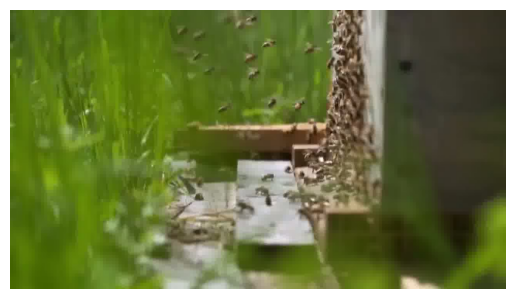

In [50]:
import matplotlib.pyplot as plt
from PIL import Image
# Compute embedding for the query
query = "Show me an insect"
query_embedding = get_text_embedding(query)

# Load the model from disk
def load_model_csv(filename="model.csv"):
    df = pd.read_csv(filename)
    df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x, sep=','))
    return df

model_df = load_model_csv("model.csv")

# Find the most similar image
def find_most_similar(model_df, new_embedding):
    embeddings = np.stack(model_df['embedding'].values)
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    new_embedding_norm = new_embedding / np.linalg.norm(new_embedding)
    similarities = embeddings_norm @ new_embedding_norm
    idx = np.argmax(similarities)
    return model_df.iloc[idx]['filename'], model_df.iloc[idx]['description']

filename, description = find_most_similar(model_df, query_embedding)
print("Most similar image filename:", filename)
print("Description:", description)

# Show image
img_path = os.path.join('frames', filename)
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [69]:
# Saving all images into a txt file
def list_images_to_txt(folder, output_txt):
    files = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    with open(output_txt, 'w') as out:
        for f in files:
            out.write( f + '\n')
    print(f"Total number of images in folder {folder} -> {len(files)}")
    print(f"Image names dave to {output_txt}")
            
list_images_to_txt('frames', 'all_images.txt')

Total number of images in folder frames -> 182
Image names dave to all_images.txt


### Task 9

In [54]:
def prompt_on_image(image_path, model="ministral-3:3b"):
    prompt = "Describe briefly what happens in this image, in English."
    response = ollama.generate(
        model=model,
        prompt=prompt,
        images=[image_path]
    )
    return response['response']

def get_text_embedding(text, model="embeddinggemma"):
    response = ollama.embeddings(
        model=model,
        prompt=text
    )
    embedding = response['embedding']
    return np.array(embedding)

def create_model_df(filenames, descriptions, embeddings):
    return pd.DataFrame({
        "filename": filenames,
        "description": descriptions,
        "embedding": embeddings
    })

def load_model_csv(filename):
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x, sep=','))
        return df
    else:
        return pd.DataFrame(columns=["filename", "description", "embedding"])

def save_model_csv(model_df, filename):
    df_to_save = model_df.copy()
    df_to_save['embedding'] = df_to_save['embedding'].apply(lambda x: ','.join(map(str, x.tolist())))
    df_to_save.to_csv(filename, index=False)

def main(images_txt, model_csv):
    # Read image filenames from text file
    with open(images_txt, 'r') as f:
        image_files = [line.strip() for line in f if line.strip()]

    # Process images
    new_filenames = []
    new_descriptions = []
    new_embeddings = []
    frames_folder = 'frames'
    for img in image_files:
        print(f"Processing: {img}")
        # desc = prompt_on_image(img)
        desc = prompt_on_image(os.path.join(frames_folder, img))
        emb = get_text_embedding(desc)
        new_filenames.append(img)
        new_descriptions.append(desc)
        new_embeddings.append(emb)

    # Create DataFrame for new results
    new_df = create_model_df(new_filenames, new_descriptions, new_embeddings)

    # Load existing model and update
    model_df = load_model_csv(model_csv)
    updated_df = pd.concat([model_df, new_df], ignore_index=True)

    # Save updated model
    save_model_csv(updated_df, model_csv)
    print(f"Model updated and saved to {model_csv}")

In [55]:
images_txt = 'all_images.txt'
model_csv = 'model.csv'
main(images_txt, model_csv)

Processing: frame_0028.jpg
Processing: frame_0162.jpg
Processing: frame_0128.jpg
Processing: frame_0151.jpg
Processing: frame_0004.jpg
Processing: frame_0076.jpg
Processing: frame_0071.jpg
Processing: frame_0032.jpg
Processing: frame_0146.jpg
Processing: frame_0026.jpg
Processing: frame_0003.jpg
Processing: frame_0047.jpg
Processing: frame_0012.jpg
Processing: frame_0073.jpg
Processing: frame_0022.jpg
Processing: frame_0104.jpg
Processing: frame_0072.jpg
Processing: frame_0174.jpg
Processing: frame_0149.jpg
Processing: frame_0123.jpg
Processing: frame_0010.jpg
Processing: frame_0055.jpg
Processing: frame_0065.jpg
Processing: frame_0119.jpg
Processing: frame_0164.jpg
Processing: frame_0148.jpg
Processing: frame_0113.jpg
Processing: frame_0081.jpg
Processing: frame_0006.jpg
Processing: frame_0109.jpg
Processing: frame_0179.jpg
Processing: frame_0040.jpg
Processing: frame_0176.jpg
Processing: frame_0108.jpg
Processing: frame_0078.jpg
Processing: frame_0131.jpg
Processing: frame_0114.jpg
P

### Test on model with all images

Most similar image filename: frame_0155.jpg
Description: This image shows a close-up of a horse's head, focusing on its eye.

The eye appears to be partially closed or resting, giving a calm and contemplative expression. The lighting highlights the texture of the horse's fur and the softness of its eyelid. The overall mood conveyed is serene and peaceful.


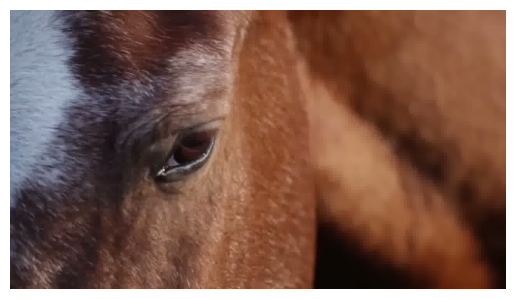

In [75]:
import matplotlib.pyplot as plt
from PIL import Image
# Compute embedding for the query
query = "Show me a horse"
query_embedding = get_text_embedding(query)

# Load the model from disk
def load_model_csv(filename="model.csv"):
    df = pd.read_csv(filename)
    df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x, sep=','))
    return df

model_df = load_model_csv("model.csv")

# Find the most similar image
def find_most_similar(model_df, new_embedding):
    embeddings = np.stack(model_df['embedding'].values)
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    new_embedding_norm = new_embedding / np.linalg.norm(new_embedding)
    similarities = embeddings_norm @ new_embedding_norm
    idx = np.argmax(similarities)
    return model_df.iloc[idx]['filename'], model_df.iloc[idx]['description']

filename, description = find_most_similar(model_df, query_embedding)
print("Most similar image filename:", filename)
print("Description:", description)

# Show image
img_path = os.path.join('frames', filename)
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()